# Library analysis, comparison, and cost efficiency calculation with OpenProtein.AI

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import spearmanr
import json

## Connect to the OpenProtein.AI API

In [2]:
import openprotein

with open('secrets.config', 'r') as f:
    config = json.load(f)

session = openprotein.connect(config['username'], config['password'])

## Load data for analysis

For this tutorial, we'll use an antibody variable fragment mutagenesis dataset, 14H. This dataset contains heavy chain variable fragment sequences mutagensized in all three CDRs with measured binding affinities.

In [3]:
path = 'data/14H_affinities_nonan.csv'
table = pd.read_csv(path)
print(table.shape)
table.head()

(7476, 2)


,sequence,log_kdnm
0,EVQLVETGGGLVQPGGSLRLSCAASPFELNSYGISWVRQAPGKGPE...,2.696930
1,EVQLVETGGGLVQPGGSLRLSCAASGFDLNSYGISWVRQAPGKGPE...,1.988077
2,EVQLVETGGGLVQPGGSLRLSCAASGFKLNSYGISWVRQAPGKGPE...,2.975487
3,EVQLVETGGGLVQPGGSLRLSCAASGFHLNSYGISWVRQAPGKGPE...,2.381006
4,EVQLVETGGGLVQPGGSLRLSCAASGFTLLSYGISWVRQAPGKGPE...,3.481793


In [4]:
# post the dataset to train a model for affinity prediction
dataset = session.data.create(table, '14H_affinities', 'Antibody heavy chain variable region mutagenesis with affinity measurements.')
dataset

AssayMetadata(assay_name='14H_affinities', assay_description='Antibody heavy chain variable region mutagenesis with affinity measurements.', assay_id='640a51ce-84b2-4c2d-8c29-5625638d827b', original_filename='assay_data', created_date=datetime.datetime(2024, 4, 1, 8, 51, 28, 875664), num_rows=7476, num_entries=7476, measurement_names=['log_kdnm'], sequence_length=118)

### Train a sequence-to-function prediction model

In [5]:
model_future = session.train.create_training_job(dataset, 'log_kdnm')
print(model_future.job)
model_future.wait_until_done(verbose=True)

status=<JobStatus.PENDING: 'PENDING'> job_id='87cfbc30-f2f5-479e-86f4-0c8b7d0ca76f' job_type='/workflow/train' created_date=datetime.datetime(2024, 4, 1, 8, 51, 35, 833518) start_date=None end_date=None prerequisite_job_id='e3173d50-ebf5-4dc6-ab51-9d607ac7ea6c' progress_message=None progress_counter=None num_records=None sequence_length=118


Waiting: 100%|██████████| 100/100 [04:15<00:00,  2.55s/it, status=SUCCESS]


True

#### Run cross validation to check model performance

In [6]:
cv_future = model_future.crossvalidate()
print(cv_future)
cv_future.wait_until_done(verbose=True)

status=<JobStatus.PENDING: 'PENDING'> job_id='be78452f-cc5a-438f-8bca-e88a253f0029' job_type='/workflow/crossvalidate' created_date=datetime.datetime(2024, 4, 1, 8, 55, 51, 83906) start_date=None end_date=None prerequisite_job_id='87cfbc30-f2f5-479e-86f4-0c8b7d0ca76f' progress_message=None progress_counter=None num_records=None sequence_length=None


Waiting:   5%|▌         | 5/100 [00:00<00:00, 330.43it/s, status=PENDING]

Waiting: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s, status=SUCCESS]


True

In [7]:
cv_results = cv_future.get()

In [11]:
y = np.array([i['y'] for i in cv_results])
y_mu = np.array([i['y_mu'] for i in cv_results])
y_var = np.array([i['y_var'] for i in cv_results])

y.shape, y_mu.shape, y_var.shape

((7476,), (7476,), (7476,))

SignificanceResult(statistic=0.6973102597245192, pvalue=0.0)


Text(0, 0.5, 'Actual affinity')

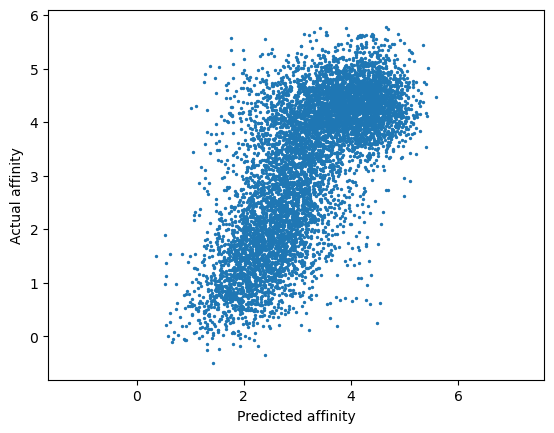

In [12]:
print(spearmanr(y_mu, y))
plt.scatter(y_mu, y, s=2)
plt.axis('equal')
plt.xlabel('Predicted affinity')
plt.ylabel('Actual affinity')

Cross validation performance is strong.

### Use the design API to identify variants with enhanced binding affinity

In [14]:
# create the design objective
# look for variants that will have single digit picomolar affinity, Kd <10 pm (< -2 log Kd)
from openprotein.api.design import ModelCriterion, Criterion, DesignJobCreate

target = -2.0
criterion = [
    [ModelCriterion(
        criterion_type = 'model',
        model_id = model_future.job.job_id,
        measurement_name = 'log_kdnm',
        criterion = Criterion(target=target, weight=1.0, direction='<')
    )]
]

# limit mutation sites to the CDRs
sites = [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         98,  99, 100, 101, 102, 103, 104, 105, 106]

site_mask = np.ones(len(table['sequence'].iloc[0]), dtype=bool)
site_mask[sites] = False
sites = np.where(site_mask)[0].tolist()
print(sites)

# run the algorithm for 50 steps with otherwise default parameters
design_params = DesignJobCreate(
    assay_id = dataset.id,
    criteria = criterion,
    num_steps = 50,
    allowed_tokens = sites,
)

design_future = session.design.create_design_job(design_params)
print(design_future.job)
design_future.wait_until_done(verbose=True)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]
status=<JobStatus.PENDING: 'PENDING'> job_id='825ab3fd-04f2-44cf-a626-a3d133bd58ab' job_type=<JobType.workflow_design: '/workflow/design'> created_date=datetime.datetime(2024, 4, 1, 9, 0, 53, 622541) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=None num_records=None sequence_length=None


Waiting:   5%|▌         | 5/100 [00:00<00:00, 324.14it/s, status=PENDING]

Waiting: 100%|██████████| 100/100 [30:04<00:00, 18.05s/it, status=SUCCESS] 


True

In [25]:
# get the design results and parse them into a table for analysis
design_results = design_future.get()

rows = []
for r in design_results:
    scores = r['scores'][0][0]
    y_mu = scores['metadata']['y_mu']
    y_var = scores['metadata']['y_var']
    score = scores['score']
    row = [r['step'], score, y_mu, y_var, r['sequence']]
    rows.append(row)
design_results = pd.DataFrame(rows, columns=['step', 'score', 'y_mu', 'y_var', 'sequence'])
print(design_results.shape)
design_results.sort_values('score', ascending=False).head()

(12800, 5)


,step,score,y_mu,y_var,sequence
6400,25,-0.927568,-1.820009,0.461417,EVQLIQTGGGLRQPGASLRLSCAASGFSLNEYGISWVRQAPGKGPE...
11264,44,-0.927568,-1.820009,0.461417,EVQLIQTGGGLRQPGASLRLSCAASGFSLNEYGISWVRQAPGKGPE...
8960,35,-0.927568,-1.820009,0.461417,EVQLIQTGGGLRQPGASLRLSCAASGFSLNEYGISWVRQAPGKGPE...
9728,38,-0.927568,-1.820009,0.461417,EVQLIQTGGGLRQPGASLRLSCAASGFSLNEYGISWVRQAPGKGPE...
8704,34,-0.927568,-1.820009,0.461417,EVQLIQTGGGLRQPGASLRLSCAASGFSLNEYGISWVRQAPGKGPE...


## Analyze possible libraries from the design results

In [26]:
design_results_filtered = design_results.drop_duplicates('sequence').sort_values(['score', 'y_mu'], ascending=[False, True])
print(design_results_filtered.shape)
design_results_filtered.head()

(4772, 5)


,step,score,y_mu,y_var,sequence
6144,24,-0.927568,-1.820009,0.461417,EVQLIQTGGGLRQPGASLRLSCAASGFSLNEYGISWVRQAPGKGPE...
5632,22,-0.935977,-1.814430,0.460085,EVQLIQTGGGLRQPGASLRLSCAASGFSLNEYGISWVRQAPGKGPE...
5889,23,-0.944747,-1.811712,0.444215,EVQLIQTGGGLVQPGASLRLSCAASGFSLNEYGISWVRQAPGKGPE...
5633,22,-0.946520,-1.815371,0.421733,EVQLIQTGGGLVSPGASLRLSCAASGFSLNEYGISWVRQAPGKGPE...
6148,24,-0.947714,-1.805165,0.465676,EVQLIQTGGGLRQPGASLRLSCAASGFSLNEYGISWVRQAPGKGPE...


In [27]:
library_1000 = design_results_filtered.iloc[:1000]
library_100 = design_results_filtered.iloc[:100]

pred_dist_1000 = scipy.stats.norm(library_1000.y_mu, np.sqrt(library_1000.y_var))
pred_dist_100 = scipy.stats.norm(library_100.y_mu, np.sqrt(library_100.y_var))

### Examine the expected distributions over affinites in the designed libraries versus the initial dataset

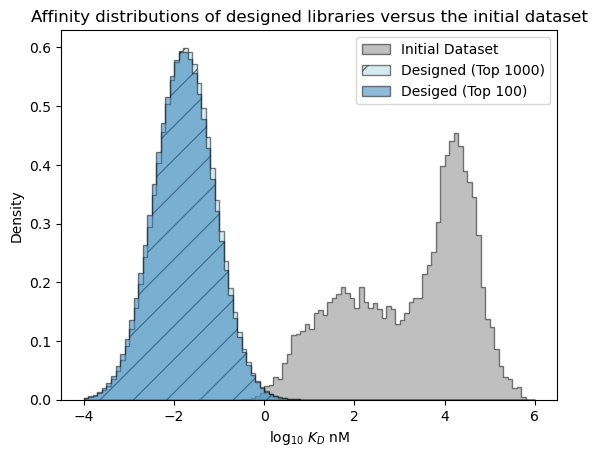

In [28]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
c_lo = pred_dist_1000.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = pred_dist_1000.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='Designed (Top 1000)', color='lightblue', hatch='/', **format_params)

c_lo = pred_dist_100.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = pred_dist_100.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='Desiged (Top 100)', **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of designed libraries versus the initial dataset')

### Examine the predictive distribution over the _best_ affinity in each library

Above, we looked at the overall expected distribution of affinities, but we may actually be interested in what the affinity value of the _best_ sequence in a library is likely to be. When comparing the libraries of size 100 and size 1,000, the affinity distributions are expected to be nearly identical, but we would expect a larger library to be *more likely* to contain a sequence that meets the design criteria (log KD < -2) and to contain a _best_ sequence with stronger affinity.

#### Probability of containing a success

In [29]:
# what is the probability that a variant meeting the design criteria is present in each library?
target = -2
print('target value <', target)

log_one_minus_p_1000 = pred_dist_1000.logsf(target)
p_1000 = 1 - np.exp(np.sum(log_one_minus_p_1000)) # the probability that at least one sequence meets the target value
print(f'Designed (Top 1000), probability of at least one success = {p_1000:.5f}')

log_one_minus_p_100 = pred_dist_100.logsf(target)
p_100 = 1 - np.exp(np.sum(log_one_minus_p_100))
print(f'Designed (Top 100), probability of at least one success = {p_100:.5f}')

target value < -2
Designed (Top 1000), probability of at least one success = 1.00000
Designed (Top 100), probability of at least one success = 1.00000


In [30]:
# in this case, we think that both libraries are virtually guaranteed to contain a successful variant!
# let's take a more fine-grained look

log_one_minus_p = pred_dist_1000.logsf(target)
print('Top k', 'Probability', sep='\t')
for i in range(20):
    p = 1 - np.exp(np.sum(log_one_minus_p[:i+1]))
    print(f'{i+1:2>d}', f'{p:.5f}', sep='\t')

Top k	Probability
1	0.39551
2	0.63260
3	0.77543
4	0.86259
5	0.91585
6	0.94841
7	0.96836
8	0.98058
9	0.98806
10	0.99265
11	0.99548
12	0.99722
13	0.99828
14	0.99894
15	0.99935
16	0.99960
17	0.99975
18	0.99985
19	0.99991
20	0.99994


As we can see, we would only need to test a few sequences to have high probability of finding one that has picomolar affinity. We can also use this kind of analysis to determine how large our library should be given a success confidence level. For example, if we wanted a library with at least 0.95 probability of containing a variant with picomolar affinity (only 1/20 chance of failure), then we would only need to test the top 17 sequences to achieve this.

In [31]:
# let's perform the same analysis but for a more aggresive affinity target value
target = -3
print('target value <', target)

log_one_minus_p_1000 = pred_dist_1000.logsf(target)
p_1000 = 1 - np.exp(np.sum(log_one_minus_p_1000)) # the probability that at least one sequence meets the target value
print(f'Designed (Top 1000), probability of at least one success = {p_1000:.5f}')

log_one_minus_p_100 = pred_dist_100.logsf(target)
p_100 = 1 - np.exp(np.sum(log_one_minus_p_100))
print(f'Designed (Top 100), probability of at least one success = {p_100:.5f}')

target value < -3
Designed (Top 1000), probability of at least one success = 1.00000
Designed (Top 100), probability of at least one success = 0.97512


In [32]:
# now we can see clearer resolution between library sizes and would need a much larger library to be confident
# that it will include a sequence with log kd < -3

log_one_minus_p = pred_dist_1000.logsf(target)
print('Top k', 'Probability', sep='\t')
for i in range(20):
    p = 1 - np.exp(np.sum(log_one_minus_p[:i+1]))
    print(f'{i+1:2>d}', f'{p:.5f}', sep='\t')

Top k	Probability
1	0.04118
2	0.07977
3	0.11409
4	0.14427
5	0.17848
6	0.20908
7	0.24061
8	0.27060
9	0.29910
10	0.32669
11	0.34851
12	0.37440
13	0.39239
14	0.41595
15	0.43848
16	0.46027
17	0.47735
18	0.49236
19	0.51105
20	0.52655


#### Predicted distribution over the best affinity in each library

Next, let's examine the distribution over the affinity of the *best* sequence we expect to see in each library.

In [33]:
# estimate best affinities in each library from sampling
num_samples = 10_000

r = np.random.randn(num_samples, 1000)*pred_dist_1000.std() + pred_dist_1000.mean()
sample_best_1000 = r.min(axis=-1)

r = np.random.randn(num_samples, 100)*pred_dist_100.std() + pred_dist_100.mean()
sample_best_100 = r.min(axis=-1)

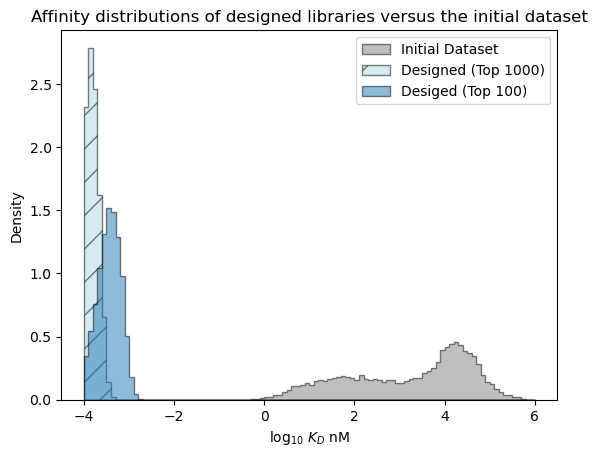

In [34]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
_ = plt.hist(sample_best_1000, bins=bins, label='Designed (Top 1000)', color='lightblue', density=True, hatch='/', **format_params)

_ = plt.hist(sample_best_100, bins=bins, label='Desiged (Top 100)', density=True, **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of designed libraries versus the initial dataset')

In [35]:
# plot out the expected best value versus library size
r = np.random.randn(num_samples, 1000)*pred_dist_1000.std() + pred_dist_1000.mean()
print('Top k', 'E[Best Affinity]', sep='\t')
for i in range(20):
    sample_best = r[:, :i+1].min(axis=-1)
    expected_best_value = sample_best.mean()
    print(f'{i+1:2>d}', f'{expected_best_value:.5f}', sep='\t')

Top k	E[Best Affinity]
1	-1.81403
2	-2.19473
3	-2.38211
4	-2.50430
5	-2.59513
6	-2.66222
7	-2.71882
8	-2.76798
9	-2.81149
10	-2.84810
11	-2.87586
12	-2.90678
13	-2.92726
14	-2.95104
15	-2.97197
16	-2.99433
17	-3.00963
18	-3.02365
19	-3.03859
20	-3.05201


### ML-designed sequences are divergent from the initial dataset

The variants we've identified are divergent from anything present in the initial dataset. Let's calculate some edit distance statistics between our top 1000 sequence library and the sequences in the initial dataset.

In [36]:
x_1000 = library_1000['sequence'].values
x_1000 = np.array([[c for c in x_1000[i]] for i in range(len(x_1000))])
print(x_1000.shape)

x_init = table['sequence'].values
x_init = np.array([[c for c in x_init[i]] for i in range(len(x_init))])
print(x_init.shape)

edit_dist = 0
for i in range(x_1000.shape[1]):
    edit_dist += (x_1000[:, i][:, np.newaxis] != x_init[:, i])
edit_dist.shape

(1000, 118)
(7476, 118)


(1000, 7476)

10 15.173 19


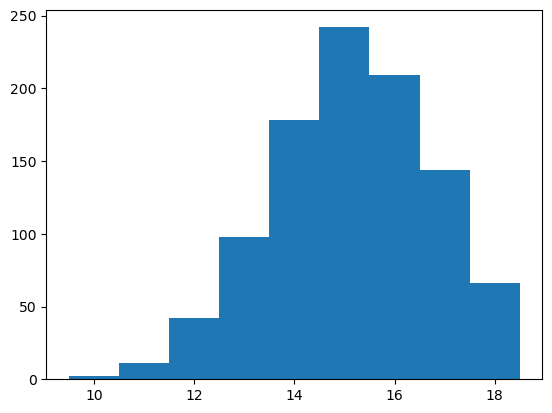

In [37]:
min_edit_dist = edit_dist.min(axis=-1)
print(min_edit_dist.min(), min_edit_dist.mean(), min_edit_dist.max())

bins = np.arange(min_edit_dist.min(), min_edit_dist.max()+1) - 0.5
_ = plt.hist(min_edit_dist, bins=bins)

Sequences in the top 1000 library are, on average, more than 6 edits away from the _most similar_ sequence in the inital library and the most divergent variant identified is *9* mutations away from anything in the initial library.

## Compare top sequences against alternative library designs

### Design a conventional combinatorial variant library (CVL)

A typical library design approach is to re-randomize the substitution variants found in the intial screen. Let's build a CVL based on the variants found in the top 50 sequences.

In [38]:
# randomize the variants found in the best sequences in the initial library
# to create a CVL

amino_acids = 'ARNDCQEGHILKMFPSTWYV'
amino_acid_to_index = {amino_acids[i]: i for i in range(len(amino_acids))}

topk = 50
sequences = table.sort_values('log_kdnm').head(n=topk)['sequence'].values
sequences = np.array([[amino_acid_to_index[sequences[i][j]] for j in range(len(sequences[i]))] for i in range(len(sequences))])
sequences.shape


(50, 118)

In [39]:
counts = np.zeros((sequences.shape[1], len(amino_acids)))
for i in range(sequences.shape[1]):
    index, count = np.unique(sequences[:, i], return_counts=True)
    counts[i, index] = count
counts = (counts > 1)
cvl = counts/counts.sum(axis=-1, keepdims=True)

/tmp/ipykernel_42434/3809225318.py:4: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  _ = ax.set_yticks(np.arange(len(amino_acids)), [c for c in amino_acids])


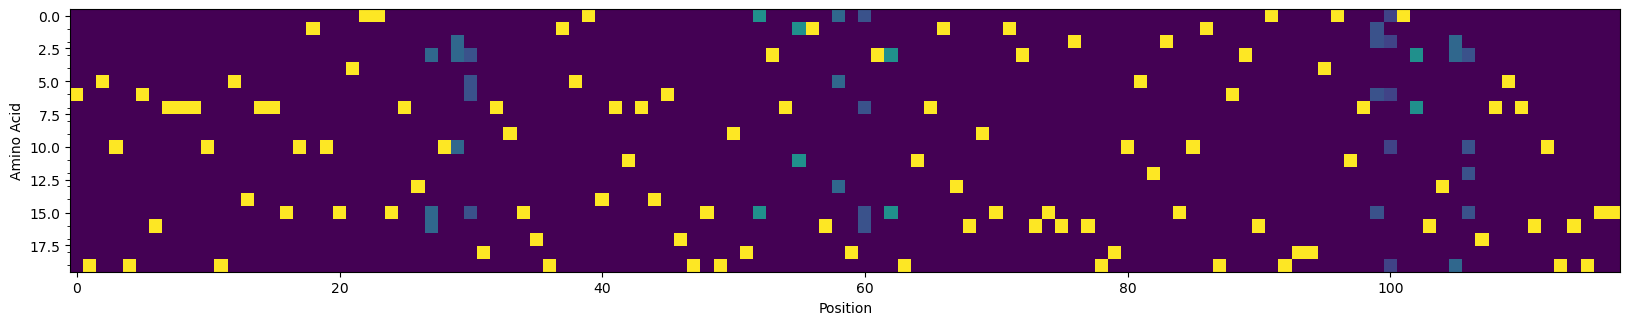

In [40]:
# visualize the CVL
_, ax = plt.subplots(figsize=(20, 4))
ax.imshow(cvl.T)
_ = ax.set_yticks(np.arange(len(amino_acids)), [c for c in amino_acids])
_ = ax.set_xlabel('Position')
_ = ax.set_ylabel('Amino Acid')

#### Assess the expected performance of the conventional CVL

In [41]:
library_size = 10_000
random = np.random.RandomState(42)
cvl_sequences_sampled = np.zeros((library_size, cvl.shape[0]), dtype=int)
for i in range(len(cvl)):
    cvl_sequences_sampled[:, i] = random.choice(len(cvl[i]), p=cvl[i], size=(library_size), replace=True)
cvl_sequences_sampled = [''.join([amino_acids[i] for i in cvl_sequences_sampled[j]]) for j in range(cvl_sequences_sampled.shape[0])]
# only consider the unique sequences
cvl_sequences_sampled = np.unique(cvl_sequences_sampled).tolist()

In [42]:
cvl_predict_future = model_future.predict(cvl_sequences_sampled)
print(cvl_predict_future.job)
cvl_predict_future.wait_until_done(verbose=True)

status=<JobStatus.PENDING: 'PENDING'> job_id='139b8c54-7c6e-47f4-9d2c-a496722a1774' job_type=<JobType.workflow_predict: '/workflow/predict'> created_date=None start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=0 num_records=None sequence_length=None result=None


Waiting: 100%|██████████| 100/100 [05:55<00:00,  3.56s/it, status=SUCCESS]


True

In [52]:
cvl_predict_results = cvl_predict_future.get()
cvl_predict_results = cvl_predict_results['log_kdnm']

cvl_y_mus = np.zeros(len(cvl_predict_results))
cvl_y_vars = np.zeros(len(cvl_predict_results))
for i,k in enumerate(cvl_predict_results.keys()):
    cvl_y_mus[i] = cvl_predict_results[k]['mean']
    cvl_y_vars[i] = cvl_predict_results[k]['variance']
cvl_dists = scipy.stats.norm(cvl_y_mus, np.sqrt(cvl_y_vars))

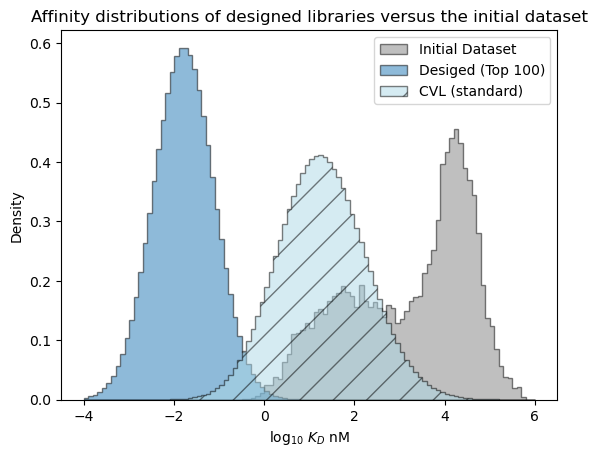

In [53]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
c_lo = pred_dist_100.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = pred_dist_100.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='Desiged (Top 100)', **format_params)

# compare the expected performance of the 10,000 sequences from the CVL
c_lo = cvl_dists.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = cvl_dists.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='CVL (standard)', color='lightblue', hatch='/', **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of designed libraries versus the initial dataset')

The expected performance of a sequence in the standard CVL is expected to be better than the average sequence in the initial dataset and may improve over the best sequences in the intial library, but is expected to be significantly worse than the sequences in the bespoke library we created with the design API.

#### Compare the library success statistics

In [54]:
# what is the probability that a variant meeting the design criteria is present in each library?
# if we tested 10,000 sequences from the CVL, how would it compare with the bespoke top 100 sequences?
target = -2
print('target value <', target)

log_one_minus_p_100 = pred_dist_100.logsf(target)
p_100 = 1 - np.exp(np.sum(log_one_minus_p_100))
print(f'Designed, 100 sequences, probability of at least one success = {p_100:.5f}')

log_one_minus_p_cvl = cvl_dists.logsf(target)
p_cvl = 1 - np.exp(np.sum(log_one_minus_p_cvl))
print(f'CVL (standard), 10,000 sequences, probability of at least one success = {p_cvl:.5f}')

target value < -2
Designed, 100 sequences, probability of at least one success = 1.00000
CVL (standard), 10,000 sequences, probability of at least one success = 0.76464


We can see that even if we test 10,000 sequences from the CVL, the probability of finding a sequence that meets our target affinity (picomolar) is only about 67%, significantly lower than the virtual certainty that a success will be contained in the bespoke 100 sequence library. If we compare this with the fine-grained results above, we can see that we would only need to test the top 3 bespoke sequence designs to have the same probability of success.

#### Predicted distribution over the best affinity in each library

Next, let's examine the distribution over the affinity of the *best* sequence we expect to see in each library.

In [55]:
cvl_dists.std().shape

(9969,)

In [56]:
# estimate best affinities in each library from sampling
num_samples = 10_000

r = np.random.randn(num_samples, len(cvl_y_mus))*cvl_dists.std() + cvl_dists.mean()
sample_cvl = r.min(axis=-1)

r = np.random.randn(num_samples, 100)*pred_dist_100.std() + pred_dist_100.mean()
sample_best_100 = r.min(axis=-1)

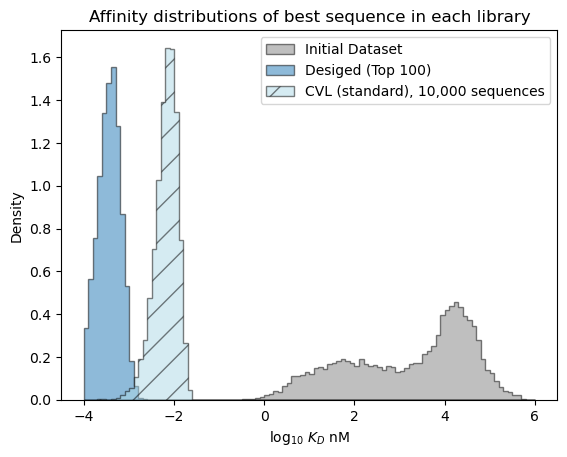

In [57]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
_ = plt.hist(sample_best_100, bins=bins, label='Desiged (Top 100)', density=True, **format_params)
_ = plt.hist(sample_cvl, bins=bins, label='CVL (standard), 10,000 sequences', color='lightblue', density=True, hatch='/', **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of best sequence in each library')

In [58]:
# plot out the expected best value versus library size
r_des = np.random.randn(num_samples, 1000)*pred_dist_1000.std() + pred_dist_1000.mean()
r_cvl = np.random.randn(num_samples, len(cvl_y_mus))*cvl_dists.std() + cvl_dists.mean()
print('Library Size', 'E[Best Affinity | Bespoke]', 'E[Best Affinity | CVL (standard)]', sep='\t')
for i in range(20):
    sample_best = r_des[:, :i+1].min(axis=-1)
    expected_best_value_des = sample_best.mean()
    sample_best = r_cvl[:, :i+1].min(axis=-1)
    expected_best_value_cvl = sample_best.mean()
    print(f'{i+1: 12d}', f'{expected_best_value_des:26.5f}', f'{expected_best_value_cvl:33.5f}', sep='\t')

Library Size	E[Best Affinity | Bespoke]	E[Best Affinity | CVL (standard)]
           1	                  -1.82551	                          1.56874
           2	                  -2.19317	                          1.11367
           3	                  -2.38496	                          0.65646
           4	                  -2.49835	                          0.31507
           5	                  -2.58975	                         -0.09489
           6	                  -2.65668	                         -0.11631
           7	                  -2.71709	                         -0.15770
           8	                  -2.76626	                         -0.17542
           9	                  -2.80954	                         -0.17675
          10	                  -2.84539	                         -0.18100
          11	                  -2.87227	                         -0.19858
          12	                  -2.90103	                         -0.24857
          13	                  -2.9220

### Design a better combinatorial variant library from the OpenProtein.AI design results

In [59]:
# randomize the variants found in the best sequences in the initial library
# to create a CVL

amino_acids = 'ARNDCQEGHILKMFPSTWYV'
amino_acid_to_index = {amino_acids[i]: i for i in range(len(amino_acids))}

sequences = library_1000['sequence'].values
sequences = np.array([[amino_acid_to_index[sequences[i][j]] for j in range(len(sequences[i]))] for i in range(len(sequences))])
sequences.shape


(1000, 118)

In [60]:
counts = np.zeros((sequences.shape[1], len(amino_acids)))
for i in range(sequences.shape[1]):
    index, count = np.unique(sequences[:, i], return_counts=True)
    counts[i, index] = count
# counts = (counts > 1)
cvl2 = counts/counts.sum(axis=-1, keepdims=True)

/tmp/ipykernel_42434/2594412836.py:4: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  _ = ax.set_yticks(np.arange(len(amino_acids)), [c for c in amino_acids])


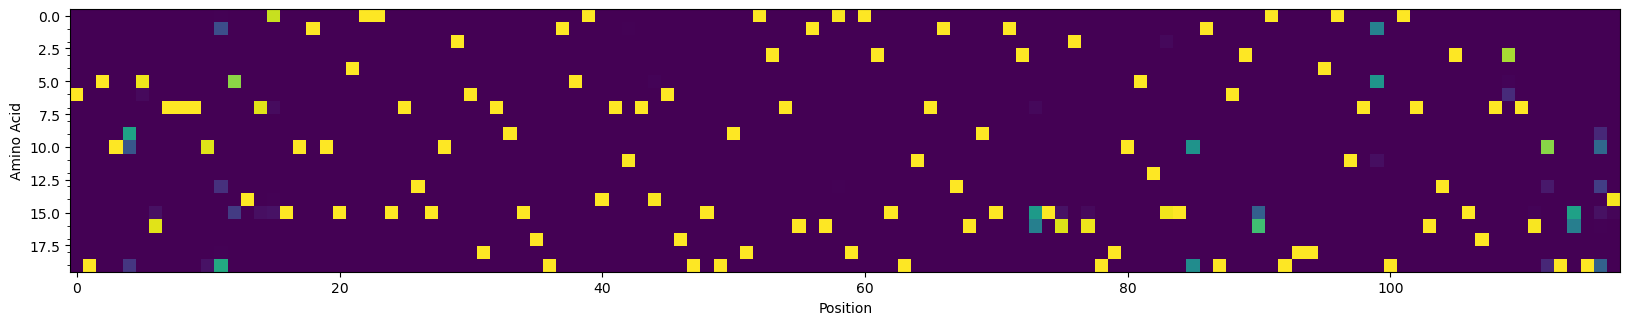

In [61]:
# visualize the CVL
_, ax = plt.subplots(figsize=(20, 4))
ax.imshow(cvl2.T)
_ = ax.set_yticks(np.arange(len(amino_acids)), [c for c in amino_acids])
_ = ax.set_xlabel('Position')
_ = ax.set_ylabel('Amino Acid')

#### Assess the expected performance of the optimized CVL

In [62]:
library_size = 10_000
random = np.random.RandomState(42)
cvl2_sequences_sampled = np.zeros((library_size, cvl2.shape[0]), dtype=int)
for i in range(len(cvl2)):
    cvl2_sequences_sampled[:, i] = random.choice(len(cvl2[i]), p=cvl2[i], size=(library_size), replace=True)
cvl2_sequences_sampled = [''.join([amino_acids[i] for i in cvl2_sequences_sampled[j]]) for j in range(cvl2_sequences_sampled.shape[0])]
# only consider the unique sequences
cvl2_sequences_sampled = np.unique(cvl2_sequences_sampled).tolist()

In [63]:
cvl2_predict_future = model_future.predict(cvl2_sequences_sampled)
print(cvl2_predict_future.job)
cvl2_predict_future.wait_until_done(verbose=True)

status=<JobStatus.PENDING: 'PENDING'> job_id='02734508-b8e8-4d2e-99ec-f37d4d1decb4' job_type=<JobType.workflow_predict: '/workflow/predict'> created_date=None start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=0 num_records=None sequence_length=None result=None


Waiting: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s, status=SUCCESS]


True

In [65]:


cvl2_predict_results = cvl2_predict_future.get()
cvl2_predict_results = cvl2_predict_results['log_kdnm']

cvl2_y_mus = np.zeros(len(cvl2_predict_results))
cvl2_y_vars = np.zeros(len(cvl2_predict_results))
for i,k in enumerate(cvl2_predict_results.keys()):
    cvl2_y_mus[i] = cvl2_predict_results[k]['mean']
    cvl2_y_vars[i] = cvl2_predict_results[k]['variance']
cvl2_dists = scipy.stats.norm(cvl2_y_mus, np.sqrt(cvl2_y_vars))


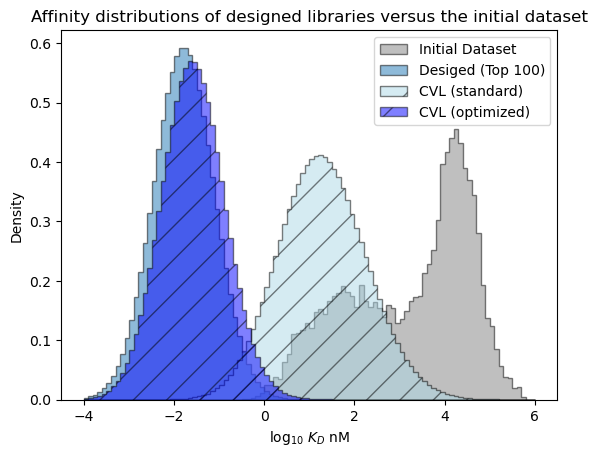

In [66]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
c_lo = pred_dist_100.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = pred_dist_100.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='Desiged (Top 100)', **format_params)

# compare the expected performance of the 10,000 sequences from the CVL
c_lo = cvl_dists.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = cvl_dists.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='CVL (standard)', color='lightblue', hatch='/', **format_params)

c_lo = cvl2_dists.cdf(bins[:-1][:, np.newaxis]).mean(axis=1)
c_hi = cvl2_dists.cdf(bins[1:][:, np.newaxis]).mean(axis=1)
weights = (c_hi - c_lo)/(bins[1:] - bins[:-1])
_ = plt.hist(bins[:-1], bins=bins, weights=weights, label='CVL (optimized)', color='blue', hatch='/', **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of designed libraries versus the initial dataset')

We can see that the CVL derived from variants identified by the design algorithm contains sequences that are expected to perform much better, on average, than the sequences in the standard CVL. Sequences in the optimized CVL are only expected to be slightly worse than the best bespoke variants we identified. 

#### Compare the library success statistics

In [67]:
# what is the probability that a variant meeting the design criteria is present in each library?
# if we tested 10,000 sequences from the CVL, how would it compare with the bespoke top 100 sequences?
target = -2
print('target value <', target)

log_one_minus_p_100 = pred_dist_100.logsf(target)
p_100 = 1 - np.exp(np.sum(log_one_minus_p_100))
print(f'Designed, 100 sequences, probability of at least one success = {p_100:.5f}')

log_one_minus_p_cvl = cvl_dists.logsf(target)
p_cvl = 1 - np.exp(np.sum(log_one_minus_p_cvl))
print(f'CVL (standard), 10,000 sequences, probability of at least one success = {p_cvl:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)[:100]
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 100 sequences, probability of at least one success = {p_cvl2:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)[:1000]
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 1,000 sequences, probability of at least one success = {p_cvl2:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 10,000 sequences, probability of at least one success = {p_cvl2:.5f}')

target value < -2
Designed, 100 sequences, probability of at least one success = 1.00000
CVL (standard), 10,000 sequences, probability of at least one success = 0.76464
CVL (optimized), 100 sequences, probability of at least one success = 1.00000
CVL (optimized), 1,000 sequences, probability of at least one success = 1.00000
CVL (optimized), 10,000 sequences, probability of at least one success = 1.00000


In [68]:
# what is the probability that a variant meeting the design criteria is present in each library?
# if we tested 10,000 sequences from the CVL, how would it compare with the bespoke top 100 sequences?
target = -3
print('target value <', target)

log_one_minus_p_100 = pred_dist_100.logsf(target)
p_100 = 1 - np.exp(np.sum(log_one_minus_p_100))
print(f'Designed, 100 sequences, probability of at least one success = {p_100:.5f}')

log_one_minus_p_cvl = cvl_dists.logsf(target)
p_cvl = 1 - np.exp(np.sum(log_one_minus_p_cvl))
print(f'CVL (standard), 10,000 sequences, probability of at least one success = {p_cvl:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)[:100]
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 100 sequences, probability of at least one success = {p_cvl2:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)[:1000]
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 1,000 sequences, probability of at least one success = {p_cvl2:.5f}')

log_one_minus_p_cvl2 = cvl2_dists.logsf(target)
p_cvl2 = 1 - np.exp(np.sum(log_one_minus_p_cvl2))
print(f'CVL (optimized), 10,000 sequences, probability of at least one success = {p_cvl2:.5f}')

target value < -3
Designed, 100 sequences, probability of at least one success = 0.97512
CVL (standard), 10,000 sequences, probability of at least one success = 0.00726
CVL (optimized), 100 sequences, probability of at least one success = 0.87172
CVL (optimized), 1,000 sequences, probability of at least one success = 1.00000
CVL (optimized), 10,000 sequences, probability of at least one success = 1.00000


We can see that even if we test 10,000 sequences from the CVL, the probability of finding a sequence that meets our target affinity (picomolar) is only about 67%, significantly lower than the virtual certainty that a success will be contained in the bespoke 100 sequence library. If we compare this with the fine-grained results above, we can see that we would only need to test the top 3 bespoke sequence designs to have the same probability of success.

#### Predicted distribution over the best affinity in each library

Next, let's examine the distribution over the affinity of the *best* sequence we expect to see in each library.

In [69]:
# estimate best affinities in each library from sampling
num_samples = 10_000

r = np.random.randn(num_samples, len(cvl_y_mus))*cvl_dists.std() + cvl_dists.mean()
sample_cvl = r.min(axis=-1)

r = np.random.randn(num_samples, len(cvl2_y_mus))*cvl2_dists.std() + cvl2_dists.mean()
sample_cvl2 = r.min(axis=-1)

r = np.random.randn(num_samples, 100)*pred_dist_100.std() + pred_dist_100.mean()
sample_best_100 = r.min(axis=-1)

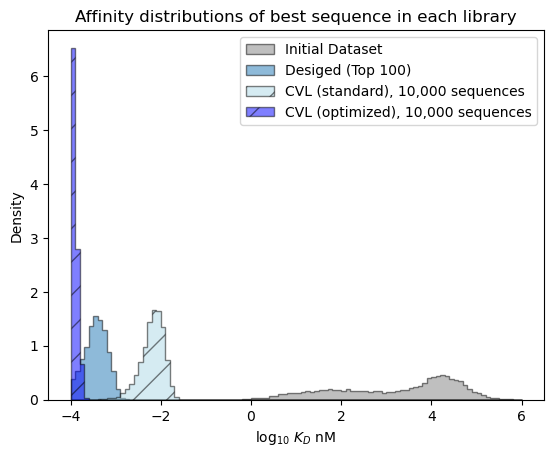

In [70]:
# plot the expected results vs. the input data
bins = np.linspace(-4, 6, 101)

format_params = {'alpha': 0.5, 'histtype': 'stepfilled', 'ec': 'k'}
_ = plt.hist(table['log_kdnm'].values, bins=bins, label='Initial Dataset', color='gray', density=True, **format_params)

# plot the predictive distribution over property values
_ = plt.hist(sample_best_100, bins=bins, label='Desiged (Top 100)', density=True, **format_params)
_ = plt.hist(sample_cvl, bins=bins, label='CVL (standard), 10,000 sequences', color='lightblue', density=True, hatch='/', **format_params)
_ = plt.hist(sample_cvl2, bins=bins, label='CVL (optimized), 10,000 sequences', color='blue', density=True, hatch='/', **format_params)

_ = plt.legend(loc='best')
_ = plt.xlabel('log$_{10}$ $K_D$ nM')
_ = plt.ylabel('Density')
_ = plt.title('Affinity distributions of best sequence in each library')

In [71]:
# plot out the expected best value versus library size
r_des = np.random.randn(num_samples, 1000)*pred_dist_1000.std() + pred_dist_1000.mean()
r_cvl = np.random.randn(num_samples, len(cvl_y_mus))*cvl_dists.std() + cvl_dists.mean()
r_cvl2 = np.random.randn(num_samples, len(cvl2_y_mus))*cvl2_dists.std() + cvl2_dists.mean()
print('Library Size', 'E[Best Affinity | Bespoke]', 'E[Best Affinity | CVL (standard)]', 'E[Best Affinity | CVL (optimized)]', sep='\t')
for i in range(20):
    sample_best = r_des[:, :i+1].min(axis=-1)
    expected_best_value_des = sample_best.mean()
    sample_best = r_cvl[:, :i+1].min(axis=-1)
    expected_best_value_cvl = sample_best.mean()
    sample_best = r_cvl2[:, :i+1].min(axis=-1)
    expected_best_value_cvl2 = sample_best.mean()
    print(f'{i+1: 12d}', f'{expected_best_value_des:26.5f}', f'{expected_best_value_cvl:33.5f}', f'{expected_best_value_cvl2:33.5f}', sep='\t')

Library Size	E[Best Affinity | Bespoke]	E[Best Affinity | CVL (standard)]	E[Best Affinity | CVL (optimized)]
           1	                  -1.81160	                          1.54256	                         -1.66513
           2	                  -2.19758	                          1.09285	                         -2.04391
           3	                  -2.38401	                          0.64673	                         -2.23419
           4	                  -2.50400	                          0.30672	                         -2.36475
           5	                  -2.59886	                         -0.09465	                         -2.44678
           6	                  -2.66848	                         -0.11635	                         -2.50422
           7	                  -2.72628	                         -0.15744	                         -2.53549
           8	                  -2.77234	                         -0.17730	                         -2.56425
           9	              